# Preprocessing of the UNSW_NB15 Dataset, model testing and training

## Introduction

This project focuses on the UNSW_NB15 dataset. The dataset contains a wide range of network features derived from simulated network traffic, including various types of attacks and normal activities.

## Dataset Source

The UNSW_NB15 dataset is publicly available and can be downloaded from the following link: [UNSW_NB15 Dataset](https://research.unsw.edu.au/projects/unsw-nb15-dataset).

## Objective

- **Preprocess the Data**: Prepare the dataset for analysis, ensuring that the data is, properly formatted, and suitable for training a neural network. This includes handling missing values, encoding categorical variables, and scaling numerical features.

- **Model Exploration**: Test various neural network configurations to identify the most effective architecture. This involves experimenting with different layers, neurons, activation functions, and regularization techniques.

- **Model Selection and Training**: Select the best-performing model based on experimentation.

- **Final Model for Prediction**: The best-performing model will then be finalized and used for making predictions. 

## Preprocessing Steps

- **Loading the Data**: Importing the dataset into our analysis environment.
- **Feature Analysis**: Understanding and exploring the features available in the dataset.
- **Data Cleaning**: Handling any missing or inconsistent data.
- **Feature Engineering**: Creating or transforming features to enhance model performance.
- **Data Scaling and Encoding**: Standardizing numerical features and encoding categorical variables to make them suitable for neural network processing.
- **Data Splitting**: Dividing the dataset into training, validation, and testing sets to ensure proper model evaluation and selection.


In [1]:
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from datetime import datetime
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.regularizers import l2

2023-12-08 18:51:34.746394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# File paths for training and testing datasets
training_file_path = '/Users/sepuliini/Desktop/UNSW_NB15_training-set.csv'
testing_file_path = '/Users/sepuliini/Desktop/UNSW_NB15_testing-set.csv'

# Load datasets into pandas DataFrames
train_full = pd.read_csv(training_file_path)
test_full = pd.read_csv(testing_file_path)

# Make a copy of the datasets to preserve the original data
train = train_full.copy()
test = test_full.copy()

# Drop irrelevant or non-predictive columns from both datasets
train.drop(['id', 'attack_cat'], axis=1, inplace=True)
test.drop(['id', 'attack_cat'], axis=1, inplace=True)

# Combine training and test datasets
combined_data = pd.concat([train, test])

In [4]:
combined_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


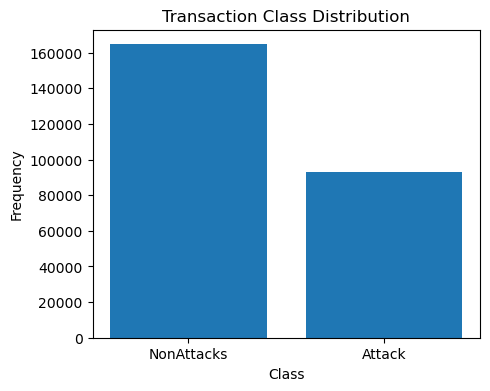

In [5]:
# Data preparation for bar chart
attack_counts = combined_data['label'].value_counts()
labels = ['NonAttacks', 'Attack']

# Bar chart
plt.figure(figsize=(5, 4))
plt.bar(labels, attack_counts)
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


In [6]:
# Set display format for floating point numbers
pd.set_option('display.float_format', lambda x: '%.6f' % x)
combined_data.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8572.951803,14387.287543,91253.912440,180.000931,84.754957,70608691.228217,658214.282490,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,5.974305,135.947152,111.985965,173773.880605,146199.281939,160344.636693,102.488268,112.762131,185731252.841730,2412372.138162,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,0.000000,1.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,114.000000,0.000000,30.789277,62.000000,0.000000,12318.004880,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.004285,4.000000,2.000000,528.000000,178.000000,2955.664893,254.000000,29.000000,743942.312500,1747.441284,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.685777,12.000000,10.000000,1362.000000,1064.000000,125000.000300,254.000000,252.000000,80000000.000000,22105.384770,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,14355774.000000,14657531.000000,1000000.003000,255.000000,254.000000,5988000256.000000,22422730.000000,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [7]:
# Scale and convert various features to appropriate units for analysis and modeling
for df in [train, test, combined_data]:
    # Convert bytes to megabytes for 'sbytes' and 'dbytes'
    df['sbytes'] = df['sbytes'] / 1048576.0
    df['dbytes'] = df['dbytes'] / 1048576.0
    
    # Convert bit rate to megabytes per second for 'sload' and 'dload'
    df['sload'] = df['sload'] / 8.0 / 1048576.0
    df['dload'] = df['dload'] / 8.0 / 1048576.0
    
    # Convert milliseconds to seconds for 'sjit', 'djit', 'sinpkt', and 'dinpkt'
    df['sjit'] = df['sjit'] / 1000.0
    df['djit'] = df['djit'] / 1000.0
    df['sinpkt'] = df['sinpkt'] / 1000.0
    df['dinpkt'] = df['dinpkt'] / 1000.0
    
    # Adjust rate scale and convert response body length to kilobytes
    df['rate'] = df['rate'] / 1000.0
    df['response_body_len'] = df['response_body_len'] / 1000.0

In [8]:
# Split training data into a smaller training set and a validation set
df_train_normal = train.sample(frac = 0.80, random_state = 42)
df_valid_normal = train.drop(df_train_normal.index)

# Split test data into an evaluation set and an unseen test set
df_test_eval = test.sample(frac=0.20, random_state=42)
df_test_unseen = test.drop(df_test_eval.index)

The dataset has a lot of categorical values so we will be performing one-hot encoding to these values to make them suitable for model training

In [9]:
# Initialize One-Hot Encoder for categorical features
enc = OneHotEncoder(handle_unknown = 'ignore')

# Transform categorical features using One-Hot Encoding for training, validation, and test sets
cols = ['service', 'state', 'proto']
enc.fit(df_train_normal.loc[:, cols])

# Training data

train_normal_cols_transformed = enc.transform(df_train_normal.loc[:, cols]).toarray()
valid_normal_cols_transformed = enc.transform(df_valid_normal.loc[:, cols]).toarray()

df_train_normal_cols_transformed = pd.DataFrame(train_normal_cols_transformed, 
                                                columns=enc.get_feature_names_out(cols), 
                                               index=df_train_normal.index )

df_train_normal_transformed = pd.concat([df_train_normal,
                                         df_train_normal_cols_transformed], axis=1).drop(columns=cols)

df_valid_normal_cols_transformed = pd.DataFrame(valid_normal_cols_transformed,
                                               columns=enc.get_feature_names_out(cols),
                                               index=df_valid_normal.index)

df_valid_normal_transformed = pd.concat([df_valid_normal, df_valid_normal_cols_transformed],
                                        axis = 1).drop(columns = cols)

# Test data

test_eval_cols_transformed = enc.transform(df_test_eval.loc[:, cols]).toarray()

df_test_eval_cols_transformed = pd.DataFrame(test_eval_cols_transformed,
                                               columns=enc.get_feature_names_out(cols),
                                               index=df_test_eval.index)

df_test_eval_transformed = pd.concat([df_test_eval, df_test_eval_cols_transformed],
                                        axis = 1).drop(columns = cols)

# Unseen data
test_unseen_cols_transformed = enc.transform(df_test_unseen.loc[:, cols]).toarray()

df_test_unseen_cols_transformed = pd.DataFrame(test_unseen_cols_transformed, 
                                               columns=enc.get_feature_names_out(cols),
                                               index=df_test_unseen.index)

df_test_unseen_transformed = pd.concat([df_test_unseen, df_test_unseen_cols_transformed], 
                                        axis=1).drop(columns=cols)

In [10]:
df_train = df_train_normal_transformed
df_valid = df_valid_normal_transformed

df_test_eval = df_test_eval_transformed
df_test_unseen = df_test_unseen_transformed

df_train.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero
38666,1.292678,52,54,0.002798,0.003567,0.081227,31,29,0.002123,0.002708,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56460,0.000007,2,0,0.000109,0.000000,142.857141,254,0,7.765634,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16266,0.000010,2,0,0.000109,0.000000,100.000003,254,0,5.435944,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75603,0.000000,1,0,0.000044,0.000000,0.000000,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11200,0.189998,10,6,0.001392,0.000256,0.078948,254,252,0.006595,0.001124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# Separate features and labels for training and validation datasets

# Training dataset
feature_columns = [col for col in df_train.columns if col not in ['label']]

X_train, y_train = df_train[feature_columns].to_numpy(), df_train['label'].to_numpy()
X_val, y_val = df_valid[feature_columns].to_numpy(), df_valid['label'].to_numpy()

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

# Testing dataset
test_feature_columns = [col for col in df_test_eval.columns if col not in ['label']]

X_test_eval = df_test_eval[test_feature_columns].to_numpy()
y_test_eval = df_test_eval['label'].to_numpy()

(65866, 188) (16466, 188)
(65866,) (16466,)


In [12]:
# Scale data using Standard Scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [13]:
# Scale test evaluation dataset separately
test_scaler = StandardScaler().fit(X_test_eval)
X_test_eval_scaled = scaler.transform(X_test_eval)

In [14]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(65866, 188) (16466, 188)
(65866,) (16466,)


In [15]:
n_features = X_train.shape[1]
input_ = Input(shape=(n_features,))
x = input_

# Print shapes of feature and label arrays for verification
print("Training Features Shape:", X_train_scaled.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Features Shape:", X_val_scaled.shape)
print("Validation Labels Shape:", y_val.shape)

Training Features Shape: (65866, 188)
Training Labels Shape: (65866,)
Validation Features Shape: (16466, 188)
Validation Labels Shape: (16466,)


In [16]:
# Preparing the unseen test data
X_test_unseen = df_test_unseen[test_feature_columns].to_numpy()
y_test_unseen = df_test_unseen['label'].to_numpy()

# Printing the shape of the unseen test features and labels for verification
print(X_test_unseen.shape, y_test_unseen.shape)

# Standardizing the unseen test data
unseen_scaler = StandardScaler().fit(X_test_unseen)
x_unseen = unseen_scaler.transform(X_test_unseen)

(140273, 188) (140273,)


In [17]:
# Directory where the datasets will be saved
save_dir = '/Users/sepuliini/Desktop/Preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save each dataset as a .npy file

np.save(os.path.join(save_dir, 'x_unseen.npy'), x_unseen)
np.save(os.path.join(save_dir, 'y_test_unseen.npy'), y_test_unseen)

This next part is a script to testing different model configurations the find one with satisfying results

In [18]:
def learning_curves(history, i, accuracy, pdf):
    # Create a figure for plotting learning curves
    fig = plt.figure(figsize=(10,4))

    # Extract the history of loss and accuracy from the training process
    hist_dict = history.history
    # Generate a list of epoch numbers (starting from 1 instead of 0)
    epochs = [x+1 for x in history.epoch]

    # Plot training and validation loss
    plt.subplot(1,2,1)  # Specify the first subplot in a 1x2 grid
    plt.plot(epochs, hist_dict['loss'], label="Training Loss")  # Training loss
    plt.plot(epochs, hist_dict['val_loss'], label="Validation Loss")  # Validation loss
    plt.title("Training and Validation Loss")  # Title of the loss plot
    plt.xlabel("Epochs")  # X-axis label
    plt.ylabel("Loss")  # Y-axis label
    plt.legend()  # Show legend to clarify which line is which

    # Plot training and validation accuracy
    plt.subplot(1,2,2)  # Specify the second subplot in a 1x2 grid
    plt.plot(epochs, hist_dict['accuracy'], label="Training Accuracy")  # Training accuracy
    plt.plot(epochs, hist_dict['val_accuracy'], label="Validation Accuracy")  # Validation accuracy
    plt.title("Training and Validation Accuracy")  # Title of the accuracy plot
    plt.xlabel("Epochs")  # X-axis label
    plt.ylabel("Accuracy")  # Y-axis label
    plt.legend()  # Show legend

    # Add a super title for the whole figure based on the configuration number and achieved accuracy
    plt.suptitle(f"Config No. {i}: >>> {accuracy*100: .5f}")
    plt.tight_layout()  # Adjust the layout to prevent overlapping

    # Save the figure to the provided PDF file
    pdf.savefig(fig)
    plt.close(fig)  # Close the figure

# Define a function to evaluate the model's performance
def evaluate_model(model, X_eval, y_eval):
    # Evaluate the model on the validation or test set
    _, accuracy = model.evaluate(X_eval, y_eval, verbose=0)
    # Print and return the accuracy
    print(f"Evaluation accuracy: {accuracy*100:.5f}")
    return accuracy

# Define a function to train the neural network model
def train_model(X_train, y_train, X_val, y_val, cfg, models_path):
    # Build the model based on the configuration and input shape
    model = build_model(X_train.shape[1], cfg)
    # Initialize the optimizer with specified learning rate
    sgd = Adam(amsgrad=True, learning_rate=cfg['lr'])
    # Compile the model with binary crossentropy loss and accuracy metric
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Set up checkpoint directory and file path
    checkpoint_dir = os.path.sep.join([models_path, 'tmp'])
    checkpoint_filepath = os.path.sep.join([checkpoint_dir, 'checkpoint'])
    
    # List of callbacks for training, including model checkpoint and CSV logger
    cbs_list = [
        ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', mode='max', save_weights_only=True, verbose=0),
        CSVLogger(os.path.sep.join([models_path, 'training_log']), append=True)
    ]
    
    # Train the model with the training data and validation data
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=cfg['epochs'], 
                        batch_size=cfg['b_size'], callbacks=cbs_list, verbose=0)
    
    # Load the best weights and clean up the checkpoint directory
    model.load_weights(checkpoint_filepath)
    shutil.rmtree(checkpoint_dir)
    
    return model, history

# Define a function to build the model architecture
def build_model(input_shape, cfg):
    # Initialize regularization based on configuration
    reg = l2(cfg['reg']) if cfg['reg'] is not None else None
    input_data = Input(shape=(input_shape,))
    x = GaussianNoise(cfg['noise'])(input_data)
    
    # Add dense layers with dropout as specified in the configuration
    for layer_size, dropout_rate in zip(cfg['layers'], cfg['dout']):
        x = Dense(layer_size, activation=cfg['act'], kernel_initializer=cfg['init'], kernel_regularizer=reg)(x)
        x = Dropout(dropout_rate)(x)
    
    # Output layer with sigmoid activation for binary classification
    output = Dense(cfg['num_classes'], activation="sigmoid")(x)
    model = Model(input_data, output)
    
    return model



def grid_search(X_train, y_train, X_val, y_val, X_test, y_test, cfgs, models_path, pdf):
    scores = []
    # Print the total number of configurations
    print(f"Total: {len(cfgs)} configurations >>> {models_path}")
    
    # Iterate over each configuration and train the model
    for i, cfg in cfgs.items():
        # Log the current configuration
        open(os.path.sep.join([models_path, 'training.log']), 'a').write(f"Current configuration {i}: {cfg} \n\n")
        # Train the model with the current configuration
        model, history = train_model(X_train, y_train, X_val, y_val, cfg, models_path)
        # Evaluate the model and store the accuracy
        accuracy = evaluate_model(model, X_test, y_test)
        
        # Plot and save learning curves
        learning_curves(history, i, accuracy, pdf)
        # Store the model's score
        scores.append((i, accuracy, model))
        
        # Save the configuration
        open(os.path.sep.join([models_path, "all_configs.txt"]), 'a').write(f"{i}: {cfg} \n")
        
        # Keep only the top 5 scores
        if len(scores) > 5:
            scores.sort(key=lambda tup: tup[1], reverse=True)
            del scores[-1]
        i += 1
        
    # Close the PDF file
    pdf.close()
    return scores

In [19]:
# Define a dictionary of parameters to test in the neural network
param_grid = {
    'layers': [[64, 42, 24, 14, 4], [64, 32, 16, 8, 4]],  # Architecture of the neural network (number of neurons in each layer)
    'reg': [None],  # Regularization (None implies no regularization)
    'dout': [[0.0, 0.0, 0.0, 0.0, 0.0], [0.4, 0.4, 0.4, 0.4, 0.4]],  # Dropout rates for each layer (0.0 implies no dropout)
    'act': ['relu','elu'],  # Activation function
    'init': ['he_uniform'],  # Weight initialization method
    'noise': [0.0],  # Gaussian noise level (0.0 implies no noise)
    "test_pct": [0.10],  # Percentage of data to be used as test data
    'lr': [0.001],  # Learning rate for the optimizer
    'epochs': [16],  # Number of training epochs
    'b_size': [16, 32],  # Batch size for training
    'num_classes': [1]  # Number of output classes (binary classification in this case)
}

# Print the number of configurations in the parameter grid
print(len(list(ParameterGrid(param_grid))))

# Create a dictionary of configurations for the grid search
cfgs = {i: cfg for i, cfg in enumerate(list(ParameterGrid(param_grid)), 1)}

# Create a timestamp for naming the model path
time = datetime.now().strftime('%Y%m%dT%H%M')
# Define the path to save models and learning curves
models_path = f'gs_dnn_{time}'

# Create the directory if it doesn't exist
if not os.path.exists(models_path):
    os.mkdir(models_path)

# Define the path for saving learning curves as a PDF
pdf_file_path = os.path.join(models_path, "learning_curves.pdf")
# Initialize a PDF file to save the learning curves
pdf = PdfPages(pdf_file_path)

16


In [108]:
# Execute the grid search with the configurations and save the scores
scores = grid_search(X_train_scaled, y_train, X_val_scaled, y_val, X_test_eval_scaled, y_test_eval, cfgs, models_path, pdf)

# Print the scores obtained from the grid search
print(scores)

Total: 16 configurations >>> gs_dnn_20231206T1218
Evaluation accuracy: 89.62587
Evaluation accuracy: 87.76377
Evaluation accuracy: 89.04129
Evaluation accuracy: 86.96247
Evaluation accuracy: 89.22094
Evaluation accuracy: 88.29702
Evaluation accuracy: 86.87407
Evaluation accuracy: 89.76275
Evaluation accuracy: 88.98711
Evaluation accuracy: 88.27421
Evaluation accuracy: 87.88354
Evaluation accuracy: 89.19813
Evaluation accuracy: 89.10403
Evaluation accuracy: 88.24854
Evaluation accuracy: 88.82742
Evaluation accuracy: 86.86267
[(8, 0.8976274728775024, <keras.src.engine.functional.Functional object at 0x19416b8d0>), (1, 0.8962587118148804, <keras.src.engine.functional.Functional object at 0x18eb58790>), (5, 0.8922094106674194, <keras.src.engine.functional.Functional object at 0x1928f0f10>), (12, 0.891981303691864, <keras.src.engine.functional.Functional object at 0x197ec8c10>), (13, 0.8910402655601501, <keras.src.engine.functional.Functional object at 0x19900b8d0>)]


In [18]:
# Training the final model based on the results gotten earlier

In [20]:
# Preparing the unseen test data
X_test_unseen = df_test_unseen[test_feature_columns].to_numpy()
y_test_unseen = df_test_unseen['label'].to_numpy()

# Printing the shape of the unseen test features and labels for verification
print(X_test_unseen.shape, y_test_unseen.shape)

(140273, 188) (140273,)


In [21]:
# Preparing the unseen test data
X_test_unseen = df_test_unseen[test_feature_columns].to_numpy()
y_test_unseen = df_test_unseen['label'].to_numpy()

# Printing the shape of the unseen test features and labels for verification
print(X_test_unseen.shape, y_test_unseen.shape)

# Standardizing the unseen test data
unseen_scaler = StandardScaler().fit(X_test_unseen)
x_unseen = unseen_scaler.transform(X_test_unseen)

(140273, 188) (140273,)


In [21]:
# Preparing the unseen test data
X_test_unseen = df_test_unseen[test_feature_columns].to_numpy()
y_test_unseen = df_test_unseen['label'].to_numpy()

# Printing the shape of the unseen test features and labels for verification
print(X_test_unseen.shape, y_test_unseen.shape)

# Standardizing the unseen test data
unseen_scaler = StandardScaler().fit(X_test_unseen)
x_unseen = unseen_scaler.transform(X_test_unseen)

# Directory where the datasets will be saved
save_dir = '/Users/sepuliini/Desktop/NN/Preprocessed_data'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save each dataset as a .npy file
np.save(os.path.join(save_dir, 'X_train_scaled.npy'), X_train_scaled)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'X_val_scaled.npy'), X_val_scaled)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'X_test_eval_scaled.npy'), X_test_eval_scaled)
np.save(os.path.join(save_dir, 'y_test_eval.npy'), y_test_eval)
np.save(os.path.join(save_dir, 'df_train.npy'), X_train_scaled)
np.save(os.path.join(save_dir, 'df_valid.npy'), df_valid)
np.save(os.path.join(save_dir, 'df_test_eval.npy'), df_test_eval)

np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'X_test_eval.npy'), X_test_eval)
np.save(os.path.join(save_dir, 'y_test_eval.npy'), y_test_eval)

np.save(os.path.join(save_dir, 'x_unseen.npy'), x_unseen)
np.save(os.path.join(save_dir, 'y_test_unseen.npy'), y_test_unseen)

(140273, 188) (140273,)


Now we will train the final model suing the results we got from earlier configurations testing

In [22]:
# Building the neural network classifier
classifier = Sequential()
# Adding Dense layers with 'elu' activation function
classifier.add(Input(shape=(n_features)))
classifier.add(Dense(64, activation='elu'))
classifier.add(Dense(48, activation='elu' ))
classifier.add(Dense(24, activation='elu'))
classifier.add(Dense(12, activation='elu'))
classifier.add(Dense(6, activation='elu'))
# Output layer with 'sigmoid' activation for binary classification
classifier.add(Dense(1, activation='sigmoid'))

# Compiling the classifier with binary crossentropy loss and accuracy metric
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

# Display the summary of the model
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12096     
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dense_2 (Dense)             (None, 24)                1176      
                                                                 
 dense_3 (Dense)             (None, 12)                300       
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16777 (65.54 KB)
Trainable params: 16777 (

In [24]:
history = classifier.fit(X_train_scaled, y_train, 
                    epochs=16, 
                    batch_size=32, 
                    validation_data=(X_val_scaled, y_val))

Epoch 1/16
2059/2059 [==============================] - 5s 2ms/step - loss: 0.1836 - accuracy: 0.9150 - val_loss: 0.1405 - val_accuracy: 0.9405
Epoch 2/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1343 - accuracy: 0.9418 - val_loss: 0.1256 - val_accuracy: 0.9489
Epoch 3/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1233 - accuracy: 0.9472 - val_loss: 0.1388 - val_accuracy: 0.9390
Epoch 4/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1183 - accuracy: 0.9493 - val_loss: 0.1231 - val_accuracy: 0.9505
Epoch 5/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1157 - accuracy: 0.9502 - val_loss: 0.1139 - val_accuracy: 0.9552
Epoch 6/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1123 - accuracy: 0.9520 - val_loss: 0.1151 - val_accuracy: 0.9545
Epoch 7/16
2059/2059 [==============================] - 3s 2ms/step - loss: 0.1084 - accuracy: 0.9534 - val_loss: 0.1279 - val_accuracy:

In [25]:
# Predicting on unseen test data
preds_scaled = classifier.predict(X_test_eval_scaled)
# Converting probabilities to binary predictions
preds = (preds_scaled > 0.5).astype('int')
preds.shape, X_test_eval_scaled

# Calculating the accuracy on unseen test data
accuracy = accuracy_score(y_test_eval, preds)

print(f"Accuracy: {accuracy}")

1096/1096 [==============================] - 1s 1ms/step
Accuracy: 0.8796908862780883


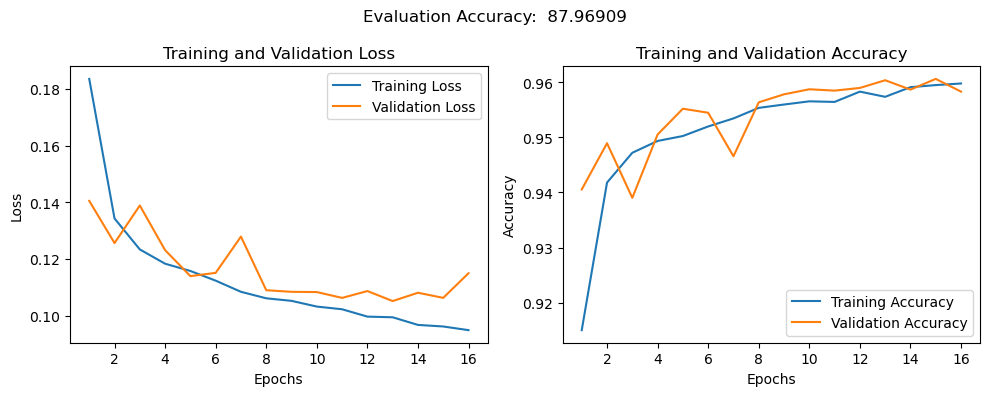

In [26]:
fig = plt.figure(figsize=(10, 4))

hist_dict = history.history
epochs = [x + 1 for x in history.epoch]

plt.subplot(1, 2, 1)
plt.plot(epochs, hist_dict['loss'], label="Training Loss")
plt.plot(epochs, hist_dict['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, hist_dict['accuracy'], label="Training Accuracy")
plt.plot(epochs, hist_dict['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle(f"Evaluation Accuracy: {accuracy*100: .5f}")
plt.tight_layout()

In [ ]:
# Saving the trained model
classifier.save("/Users/sepuliini/Desktop/NN")